In [36]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def tryconvert(value, default, *types):
    for t in types:
        try:
            return t(value)
        except (ValueError, TypeError):
            continue
    return default

In [37]:
zip3 = pd.DataFrame({"zip3": [z for z in range(1000)]})
year = pd.DataFrame({"year": [y for y in range(2014, 2019)]})
month = pd.DataFrame({"month": [y for y in range(1, 13)]})

by_zip3 = zip3.join(year, how='cross')
by_zip3 = by_zip3.join(month, how='cross')

DEMOGRAPHICS

In [38]:
demog = pd.read_csv('data/demographic_cleaned.csv')

In [39]:
demog = demog.groupby(['zip3', 'YEAR', 'MONTH']).nth(0).reset_index()

In [40]:
by_zip3 = by_zip3.merge(demog, left_on=['year', 'month', 'zip3'], right_on=['YEAR', 'MONTH', 'zip3'], how='left')

POPULATION

In [41]:
pop_by_zip = pd.read_csv("data/population_by_zip_2010.csv")

In [42]:
pop_by_zip = pop_by_zip.groupby([pop_by_zip['zipcode'] // 100, 'gender'])['population'].sum()

In [43]:
pop_by_zip = pop_by_zip.unstack(1)
pop_by_zip.rename(columns={"female": "pop_female", "male":"pop_male"}, inplace=True)

In [44]:
by_zip3 = by_zip3.merge(pop_by_zip, left_on=['zip3'], right_on=['zipcode'], how='left')

AVERAGE GROSS INCOME

In [45]:
income_by_zip = pd.read_csv("data/IRSIncomeByZipCode.csv")

In [46]:
income_by_zip.columns

Index(['STATE', 'ZIPCODE', 'Number of returns', 'Adjusted gross income (AGI)', 'Avg AGI', 'Number of returns with total income', 'Total income amount', 'Avg total income', 'Number of returns with taxable income', 'Taxable income amount', 'Avg taxable income'], dtype='object')

In [47]:
# income_by_zip = income_by_zip.groupby([income_by_zip['ZIPCODE'] // 100])[['Number of returns', 'Adjusted gross income (AGI)']].sum()
# df['agi_mean'] = df['Adjusted gross income (AGI)'] / df['Number of returns']

BANK CHARACTERISTICS

In [48]:
loan_by_zip = pd.read_csv("data/SDI/All_Reports_{0}{1}/All_Reports_{0}{1}_Net Loans and Leases.csv".format(2014, "0331"))

In [49]:
loan_by_zip = loan_by_zip.groupby(loan_by_zip['zip']//100)[['lncrcd', 'lncrcd']].sum().reset_index()

In [50]:
quarters = [["0331", 1], ["0630", 2], ["0930", 3], ["1231", 4]]
loan_by_zip_all = []

for year in range(2014, 2019):
    for c, q in quarters:
        loan_by_zip = pd.read_csv("data/SDI/All_Reports_{0}{1}/All_Reports_{0}{1}_Net Loans and Leases.csv".format(year, c))
        loan_by_zip = loan_by_zip.groupby(loan_by_zip['zip']//100)[['lncon', 'lncrcd']].sum().reset_index()
        loan_by_zip['year'] = year
        loan_by_zip['quarter'] = q
        loan_by_zip_all.append(loan_by_zip)
        
loan_by_zip_all = pd.concat(loan_by_zip_all)

In [51]:
import numpy as np
by_zip3['quarter'] = np.ceil(by_zip3['month'] / 3)

In [52]:
by_zip3 = by_zip3.merge(loan_by_zip_all, left_on=['zip3', 'year', 'quarter'], right_on=['zip', 'year', 'quarter'], how='left')

P2P LOAN APPLICATIONS

In [53]:
p2p_acc = pd.read_csv("data/LC/Lending_Club_Accepted_2014_2018.csv")
p2p_rej = pd.read_csv("data/LC/Lending_Club_Rejected_2014_2018.csv")

/var/folders/5t/fxl9hmt15b9gy4kpwg48tz2w0000gn/T/ipykernel_1984/3470390931.py:1: DtypeWarning: Columns (19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  p2p_acc = pd.read_csv("data/LC/Lending_Club_Accepted_2014_2018.csv")


In [54]:
p2p_acc['month'] = pd.to_datetime(p2p_acc['issue_d']).dt.month
p2p_acc['year'] = pd.to_datetime(p2p_acc['issue_d']).dt.year
p2p_acc['zip_code'] = p2p_acc['zip_code'].apply(lambda x: tryconvert(str(x)[:3], 0, int))

In [55]:
p2p_rej['month'] = pd.to_datetime(p2p_rej['Application_Date']).dt.month
p2p_rej['year'] = pd.to_datetime(p2p_rej['Application_Date']).dt.year
p2p_rej['zip_code'] = p2p_rej['Zip_Code'].apply(lambda x: tryconvert(str(x)[:3], 0, int))

In [56]:
mean_cols = p2p_acc.select_dtypes(include=[float]).columns
p2p_acc_gb = p2p_acc.groupby(['zip_code', 'year', 'month'])[mean_cols].mean()
p2p_acc_gb['count'] = p2p_acc.groupby(['zip_code', 'year', 'month']).size()
p2p_acc_gb = p2p_acc_gb.reset_index()
p2p_acc_gb['quarter'] = np.ceil(p2p_acc_gb['month'] / 3)

In [57]:
df = p2p_acc_gb
df['day'] = 1
df['month'] = df['quarter'] * 3
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.groupby('date').mean()

<AxesSubplot:xlabel='date'>

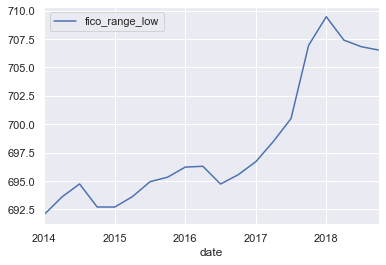

In [58]:
df.plot(y='fico_range_low', use_index=True)

<AxesSubplot:xlabel='date'>

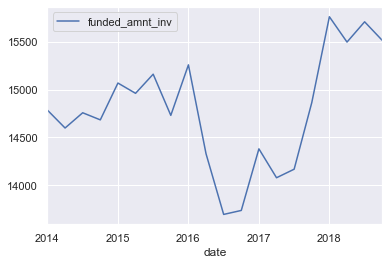

In [59]:
df.plot(y='funded_amnt_inv', use_index=True)

<AxesSubplot:xlabel='date'>

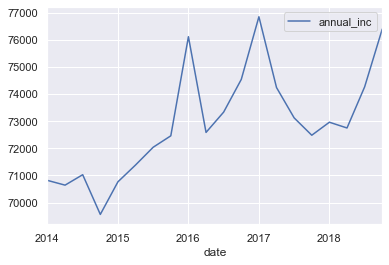

In [60]:
df.plot(y='annual_inc', use_index=True)

<AxesSubplot:xlabel='date'>

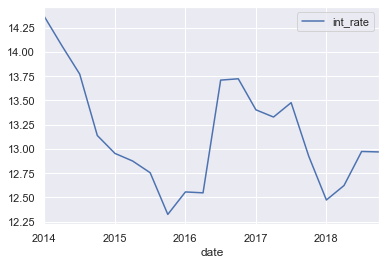

In [61]:
df.plot(y='int_rate', use_index=True)

<AxesSubplot:xlabel='date'>

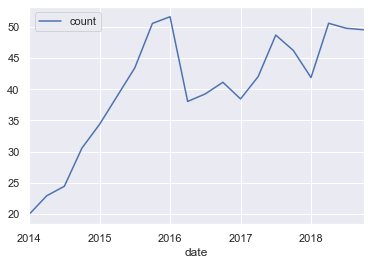

In [62]:
df.plot(y='count', use_index=True)

In [63]:
df2 = by_zip3
df2['day'] = 1
df2['month'] = df2['quarter'] * 3
df2['date'] = pd.to_datetime(df2[['year', 'month', 'day']])
df2 = df2.groupby('date').sum()

<AxesSubplot:xlabel='date'>

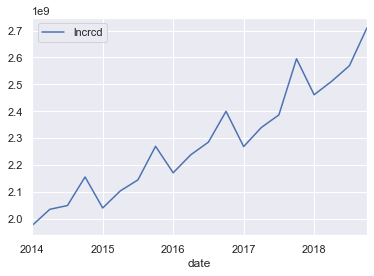

In [64]:
df2.plot(y='lncrcd', use_index=True)

<AxesSubplot:xlabel='date'>

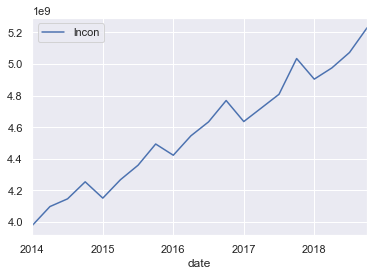

In [65]:
df2.plot(y='lncon', use_index=True)

In [66]:
df3 = df2.merge(df, on='date')

In [67]:
for c in df3.columns:
    print('\''+c+'\'', end=" | ")

'zip3' | 'year_x' | 'month_x' | 'YEAR' | 'MONTH' | 'STATEFIP' | 'COUNTY' | 'FAMINC' | 'is_black' | 'is_asian' | 'is_white' | 'is_college' | 'STCOUNTYFP' | 'pop_female' | 'pop_male' | 'quarter_x' | 'zip' | 'lncon' | 'lncrcd' | 'day_x' | 'zip_code' | 'year_y' | 'month_y' | 'member_id' | 'loan_amnt' | 'funded_amnt' | 'funded_amnt_inv' | 'int_rate' | 'installment' | 'annual_inc' | 'dti' | 'delinq_2yrs' | 'fico_range_low' | 'fico_range_high' | 'inq_last_6mths' | 'mths_since_last_delinq' | 'mths_since_last_record' | 'open_acc' | 'pub_rec' | 'revol_bal' | 'revol_util' | 'total_acc' | 'out_prncp' | 'out_prncp_inv' | 'total_pymnt' | 'total_pymnt_inv' | 'total_rec_prncp' | 'total_rec_int' | 'total_rec_late_fee' | 'recoveries' | 'collection_recovery_fee' | 'last_pymnt_amnt' | 'last_fico_range_high' | 'last_fico_range_low' | 'collections_12_mths_ex_med' | 'mths_since_last_major_derog' | 'policy_code' | 'annual_inc_joint' | 'dti_joint' | 'acc_now_delinq' | 'tot_coll_amt' | 'tot_cur_bal' | 'open_acc

<AxesSubplot:>

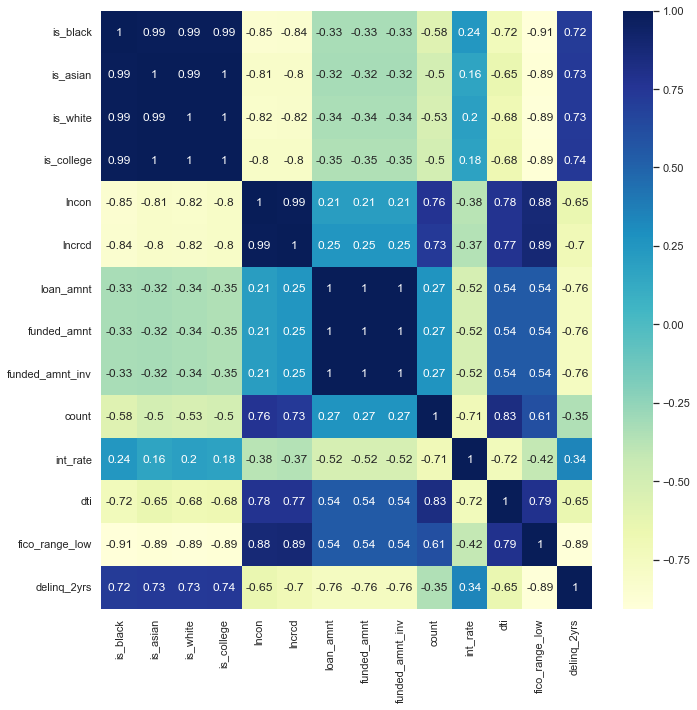

In [68]:
corr = df3[['is_black', 'is_asian', 'is_white', 'is_college', 'lncon', 'lncrcd', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'count', 'int_rate', 
    'dti', 'fico_range_low', 'delinq_2yrs']].corr()

sns.set(rc={'figure.figsize':(11,11)})
sns.heatmap(corr, cmap="YlGnBu", annot=True)

ROUGH

In [69]:
# sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [70]:
# import statsmodels.formula.api as sm
# result = sm.ols(formula="num_acc_p2p ~ lnlsnet + agi_mean", data=df).fit()
# print(result.params)
# print(result.summary())

In [1]:
import requests
import pandas as pd

url = 'http://zipatlas.com/us/zip-code-comparison/percentage-arab-population.htm'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[-1]
print(df)
df.to_csv('my data.csv')


                                                   0  \
0  % Apart./Condos % Arabs % Asians % Blacks % Bo...   

                                                   1  \
0  % Greeks % H/Income < $10k % H/Income > $100k ...   

                                                   2  \
0  % Irish % Italians % Japanese % Korens % Lithu...   

                                                   3  
0  % Seniors Over 65 % Service Jobs % Slovaks % S...  


In [2]:
df

,0,1,2,3
0,% Apart./Condos % Arabs % Asians % Blacks % Bo...,% Greeks % H/Income < $10k % H/Income > $100k ...,% Irish % Italians % Japanese % Korens % Lithu...,% Seniors Over 65 % Service Jobs % Slovaks % S...
